In [166]:
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as scs
import statsmodels.tsa.api as smt
import warnings
warnings.filterwarnings("ignore")
import datetime
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from xgboost import XGBRegressor
from xgboost import plot_importance
import time
from itertools import product
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

In [3]:
df_train = pd.read_csv('sales_train_v2.csv',sep=',')

In [162]:
df_train.head()

df_train = df_train[((df_train.item_price<1001)&(df_train.item_price>0))]

In [10]:
df_train.date = df_train.date.apply(lambda x: datetime.datetime.strptime(x, '%d.%m.%Y'))

In [11]:
df_train.date.head()

0   2013-01-02
1   2013-01-03
2   2013-01-05
3   2013-01-06
4   2013-01-15
Name: date, dtype: datetime64[ns]

In [13]:
month_sales = df_train.groupby(['date_block_num', 'shop_id','item_id'])['date','item_price','item_cnt_day'].agg({'date':['min','max'], 'item_price':'mean', 'item_cnt_day':'sum'})

In [14]:
month_sales.head()

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0

In [17]:
item_cat=pd.read_csv("item_categories.csv")
item=pd.read_csv("items.csv")
sub=pd.read_csv("sample_submission.csv")
shops=pd.read_csv("shops.csv")
test=pd.read_csv("test.csv")

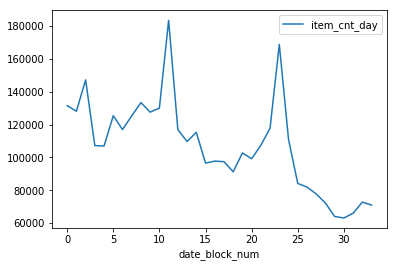

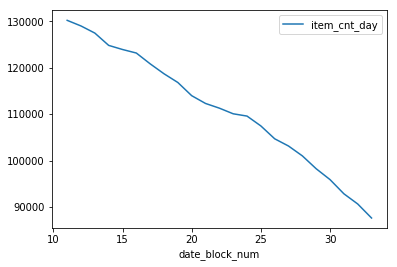

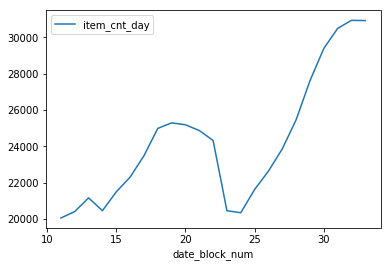

In [40]:
ts = df_train.groupby(['date_block_num']).agg({'item_cnt_day':'sum'})
ts.plot()
ts.rolling(window=12, center=False).mean().plot()
ts.rolling(window=12, center=False).std().plot()

#mean of the series should not be a function of time
#std of the series should not be a funciton of time
#covariance of the ith term and the (i+m)th term should not be a function of time

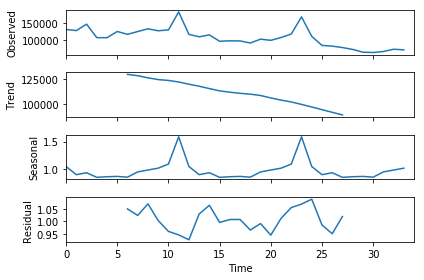

In [41]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative") # multiplicative : yt=St x Tt x Et
#plt.figure(figsize=(16,12))
fig = res.plot()

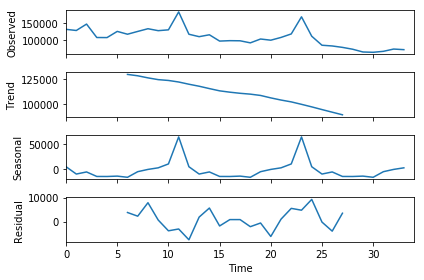

In [42]:
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive") # additive : yt=St+Tt+Et
#plt.figure(figsize=(16,12)) 
fig = res.plot()

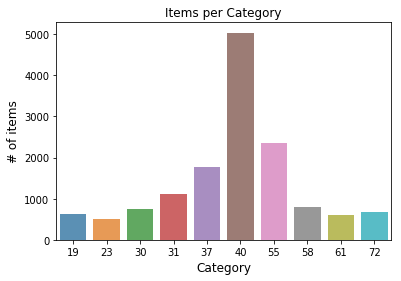

In [26]:
x = item.groupby(['item_category_id']).count()
x = x.sort_values(by='item_id',ascending=False)
x = x.iloc[0:10].reset_index()
ax = sns.barplot(x.item_category_id, x.item_id, alpha = 0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

In [95]:
# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.iloc[:,0].values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#adfuller accepte only 1-d values

In [61]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)
# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

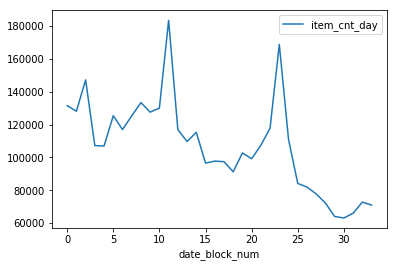

In [72]:
ts = df_train.groupby(['date_block_num']).agg({'item_cnt_day':'sum'})
ts.plot()

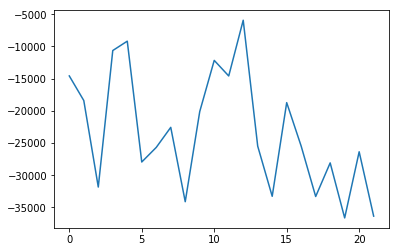

In [109]:
new_ts = difference(ts.values,12)
plt.plot(new_ts)

In [98]:
test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [115]:
#test_stationarity(new_ts)
new_ts1 = []
for i in new_ts:
    new_ts1.append(i[0])

In [130]:
test_stationarity(pd.DataFrame(new_ts1))

Results of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


In [132]:
#create a arma(2,2) to test the detective function  
n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.8, -0.65])
betas = np.array([0.5, -0.7])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)

best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for j in range(5):
        try:
            tmp_mdl = smt.ARMA(arma22, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue

print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 15523.89629 | order: (2, 2)


In [133]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for j in range(5):
        try:
            tmp_mdl = smt.ARMA(new_ts.values, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue

print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 472.99703 | order: (1, 1)


In [144]:
sales = df_train.groupby(["shop_id","item_id","date_block_num"])["item_cnt_day"].sum()
sales.head()

shop_id  item_id  date_block_num
0        30       1                 31.0
         31       1                 11.0
         32       0                  6.0
                  1                 10.0
         33       0                  3.0
Name: item_cnt_day, dtype: float64

In [145]:
sales = sales.unstack(level=-1).fillna(0)
sales.head()

date_block_num    0     1    2    3    4    5    6    7    8    9  ...    24  \
shop_id item_id                                                    ...         
0       30       0.0  31.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        31       0.0  11.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        32       6.0  10.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        33       3.0   3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   
        35       1.0  14.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0   

date_block_num    25   26   27   28   29   30   31   32   33  
shop_id item_id                                               
0       30       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        31       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        32       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        33       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        35       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 34 columns]

In [146]:
sales = sales.T
dates=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
sales.index=dates
sales=sales.reset_index()
sales.head()

shop_id      index     0                                             ...   \
item_id               30    31    32   33    35   36   40   42   43  ...    
0       2013-01-01   0.0   0.0   6.0  3.0   1.0  0.0  0.0  0.0  1.0  ...    
1       2013-02-01  31.0  11.0  10.0  3.0  14.0  1.0  1.0  1.0  0.0  ...    
2       2013-03-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...    
3       2013-04-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...    
4       2013-05-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...    

shop_id    59                                                        
item_id 22144 22145 22150 22151 22153 22154 22155 22162 22164 22167  
0         0.0   0.0   0.0   2.0   0.0   1.0   0.0   0.0   0.0   0.0  
1         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2         0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 424125 columns]

In [154]:
len(df_train.shop_id.unique())

60

In [209]:
train  = df_train
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts

10.441814422607422

In [210]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
time.time() - ts

4.931758165359497

In [211]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [212]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts

0.209794282913208

In [198]:
item_cat=pd.read_csv("item_categories.csv")
items=pd.read_csv("items.csv")
sub=pd.read_csv("sample_submission.csv")
shops=pd.read_csv("shops.csv")
test=pd.read_csv("test.csv")

In [213]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, item_cat, on=['item_category_id'], how='left')

time.time() - ts

7.317539691925049

### create lag 1,2,3,6,12 for each shop, each item

In [218]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [219]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

39.802542209625244

#### add M-1 global mean
#### add M-1 mean for each item
#### add M-1 mean for each shop
#### add M-1 mean for each item_category
#### add M-1 mean for each shop_item_category

In [221]:
ts = time.time()
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

16.214898586273193

In [222]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

51.9757285118103

In [223]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

54.73022150993347

In [224]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

21.00656223297119

In [225]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

21.22081446647644

#### price trend for the last six months lag = 1-6
#### Last month shop revenue trend
#### month varialbe , Number of days in a month



In [227]:
matrix['month'] = matrix['date_block_num'] % 12

days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)


In [228]:
ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
time.time() - ts

1.1091420650482178

In [229]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

10.588733673095703

In [230]:
matrix.to_pickle('data.pkl')

#### Modelling

In [231]:
data = pd.read_pickle('data.pkl')

In [232]:
data.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'ID',
       'shop_name', 'item_name', 'item_category_id', 'item_category_name',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'date_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_6', 'date_item_avg_item_cnt_lag_12',
       'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_2',
       'date_shop_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_6',
       'date_shop_avg_item_cnt_lag_12', 'date_cat_avg_item_cnt_lag_1',
       'date_shop_cat_avg_item_cnt_lag_1', 'month', 'days'],
      dtype='object')

In [235]:
data = data.drop(['ID','shop_name','item_name','item_category_name'],axis=1)

In [236]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [238]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[18:14:03] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[0]	validation_0-rmse:1.03678	validation_1-rmse:1.02102
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.996707	validation_1-rmse:0.990705
[2]	validation_0-rmse:0.963802	validation_1-rmse:0.966708
[3]	validation_0-rmse:0.935811	validation_1-rmse:0.946616
[4]	validation_0-rmse:0.910711	validation_1-rmse:0.928178
[5]	validation_0-rmse:0.889617	validation_1-rmse:0.912395
[6]	validation_0-rmse:0.872455	validation_1-rmse:0.900203
[7]	validation_0-rmse:0.857588	validation_1-rmse:0.889014
[8]	validation_0-rmse:0.84678	validation_1-rmse:0.880256
[9]	validation_0-rmse:0.835788	validation_1-rmse:0.872913
[10]	validation_0-rmse:0.82657	validation_1-rmse:0.86649
[11]	validation_0-rmse:0.818664	val

1429.6895365715027

In [ ]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

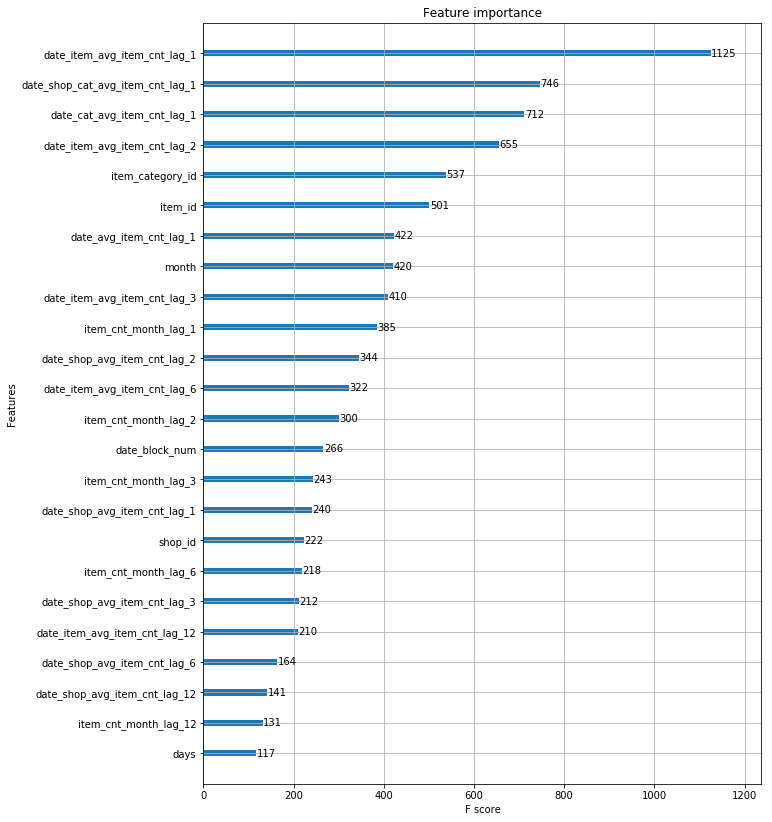

In [239]:
plot_features(model, (10,14))

In [241]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

In [248]:
def baseline_model():
    model = Sequential()
    model.add(Dense(20, input_dim=X_train.shape[1], kernel_initializer='uniform', activation='softplus'))
    model.add(Dense(1, kernel_initializer='uniform', activation = 'relu'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [249]:
estimator = KerasRegressor(build_fn=baseline_model, verbose=1, epochs=5, batch_size = 55000)
estimator.fit(X_train.values, Y_train.ravel())

Epoch 1/5
5066422/5066422 [==============================] - 14s 3us/step - loss: 1.1930
Epoch 2/5
5066422/5066422 [==============================] - 9s 2us/step - loss: 1.1788
Epoch 3/5
5066422/5066422 [==============================] - 10s 2us/step - loss: 1.1847
Epoch 4/5
5066422/5066422 [==============================] - 10s 2us/step - loss: 1.1788
Epoch 5/5
5066422/5066422 [==============================] - 8s 2us/step - loss: 1.1788


In [250]:
pred_test = estimator.predict(X_valid)

171424/171424 [==============================] - 0s 1us/step


In [253]:
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(pred_test, Y_valid))

1.0456996

In [ ]:







pred_test = estimator.predict(test_x)

preds.append(pred_test)

run = time.perf_counter() - start
print('{} runs for {:.2f} seconds.'.format('Keras', run))

cur_month_run_total = time.perf_counter() - start_cur_month

print('Total running time was {:.2f} minutes.'.format(cur_month_run_total/60))
print('-' * 50)

slice_end = slice_start + cur_X_test.shape[0]
X_all_level2[ slice_start : slice_end , :] = np.c_[preds].transpose()
slice_start = slice_end

test_nrow = len(preds[0])
X_train_level2 = X_all_level2[ : -test_nrow, :]
X_test_level2 = X_all_level2[ -test_nrow: , :]
y_train_level2 = y_all_level2[ : -test_nrow]
y_test_level2 = y_all_level2[ -test_nrow : ]
print('%0.2f min: Finish training First level models'%((time.perf_counter() - start_first_level_total)/60))
